In [1]:
!mkdir -p ~/.kaggle
!cp /content/drive/MyDrive/kaggle.json ~/.kaggle/
!chmod 600 /content/drive/MyDrive/kaggle.json

In [2]:
# download dataset from kaggle
!kaggle competitions download -c playground-series-s4e12

playground-series-s4e12.zip: Skipping, found more recently modified local copy (use --force to force download)


In [3]:
# extract zip file
from zipfile import ZipFile
file_name = "playground-series-s4e12.zip"
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


### **Import dependencies**

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, StandardScaler, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_squared_log_error
from sklearn.pipeline import Pipeline
from warnings import filterwarnings
filterwarnings('ignore')

In [5]:
data = pd.read_csv("train.csv")

In [6]:
data.head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,...,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
0,0,19.0,Female,10049.0,Married,1.0,Bachelor's,Self-Employed,22.598761,Urban,...,2.0,17.0,372.0,5.0,2023-12-23 15:21:39.134960,Poor,No,Weekly,House,2869.0
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,...,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,...,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,...,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
4,4,21.0,Male,39651.0,Single,1.0,Bachelor's,Self-Employed,20.376094,Rural,...,0.0,8.0,598.0,4.0,2021-12-01 15:21:39.252145,Poor,Yes,Weekly,House,2022.0


In [7]:
data.shape

(1200000, 21)

In [8]:
# check out columns of the dataset
data.columns

Index(['id', 'Age', 'Gender', 'Annual Income', 'Marital Status',
       'Number of Dependents', 'Education Level', 'Occupation', 'Health Score',
       'Location', 'Policy Type', 'Previous Claims', 'Vehicle Age',
       'Credit Score', 'Insurance Duration', 'Policy Start Date',
       'Customer Feedback', 'Smoking Status', 'Exercise Frequency',
       'Property Type', 'Premium Amount'],
      dtype='object')

In [9]:
# Null values in the data
null_data = data.isnull().sum().to_frame()
null_data['Null_Percetange'] = round((null_data/len(data))*100, 3)
null_data

,0,Null_Percetange
id,0,0.000
Age,18705,1.559
Gender,0,0.000
Annual Income,44949,3.746
Marital Status,18529,1.544
Number of Dependents,109672,9.139
Education Level,0,0.000
Occupation,358075,29.840
Health Score,74076,6.173
Location,0,0.000


In [10]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_columns', 50)

In [11]:
data[data.isnull().any(axis=1)].head()

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
1,1,39.0,Female,31678.0,Divorced,3.0,Master's,NaN,15.569731,Rural,Comprehensive,1.0,12.0,694.0,2.0,2023-06-12 15:21:39.111551,Average,Yes,Monthly,House,1483.0
2,2,23.0,Male,25602.0,Divorced,3.0,High School,Self-Employed,47.177549,Suburban,Premium,1.0,14.0,NaN,3.0,2023-09-30 15:21:39.221386,Good,Yes,Weekly,House,567.0
3,3,21.0,Male,141855.0,Married,2.0,Bachelor's,NaN,10.938144,Rural,Basic,1.0,0.0,367.0,1.0,2024-06-12 15:21:39.226954,Poor,Yes,Daily,Apartment,765.0
5,5,29.0,Male,45963.0,Married,1.0,Bachelor's,NaN,33.053198,Urban,Premium,2.0,4.0,614.0,5.0,2022-05-20 15:21:39.207847,Average,No,Weekly,House,3202.0
6,6,41.0,Male,40336.0,Married,0.0,PhD,NaN,NaN,Rural,Basic,2.0,8.0,807.0,6.0,2020-02-21 15:21:39.219432,Poor,No,Weekly,House,439.0


In [12]:
data.drop(columns=['id', 'Policy Start Date'], axis=1, inplace=True)

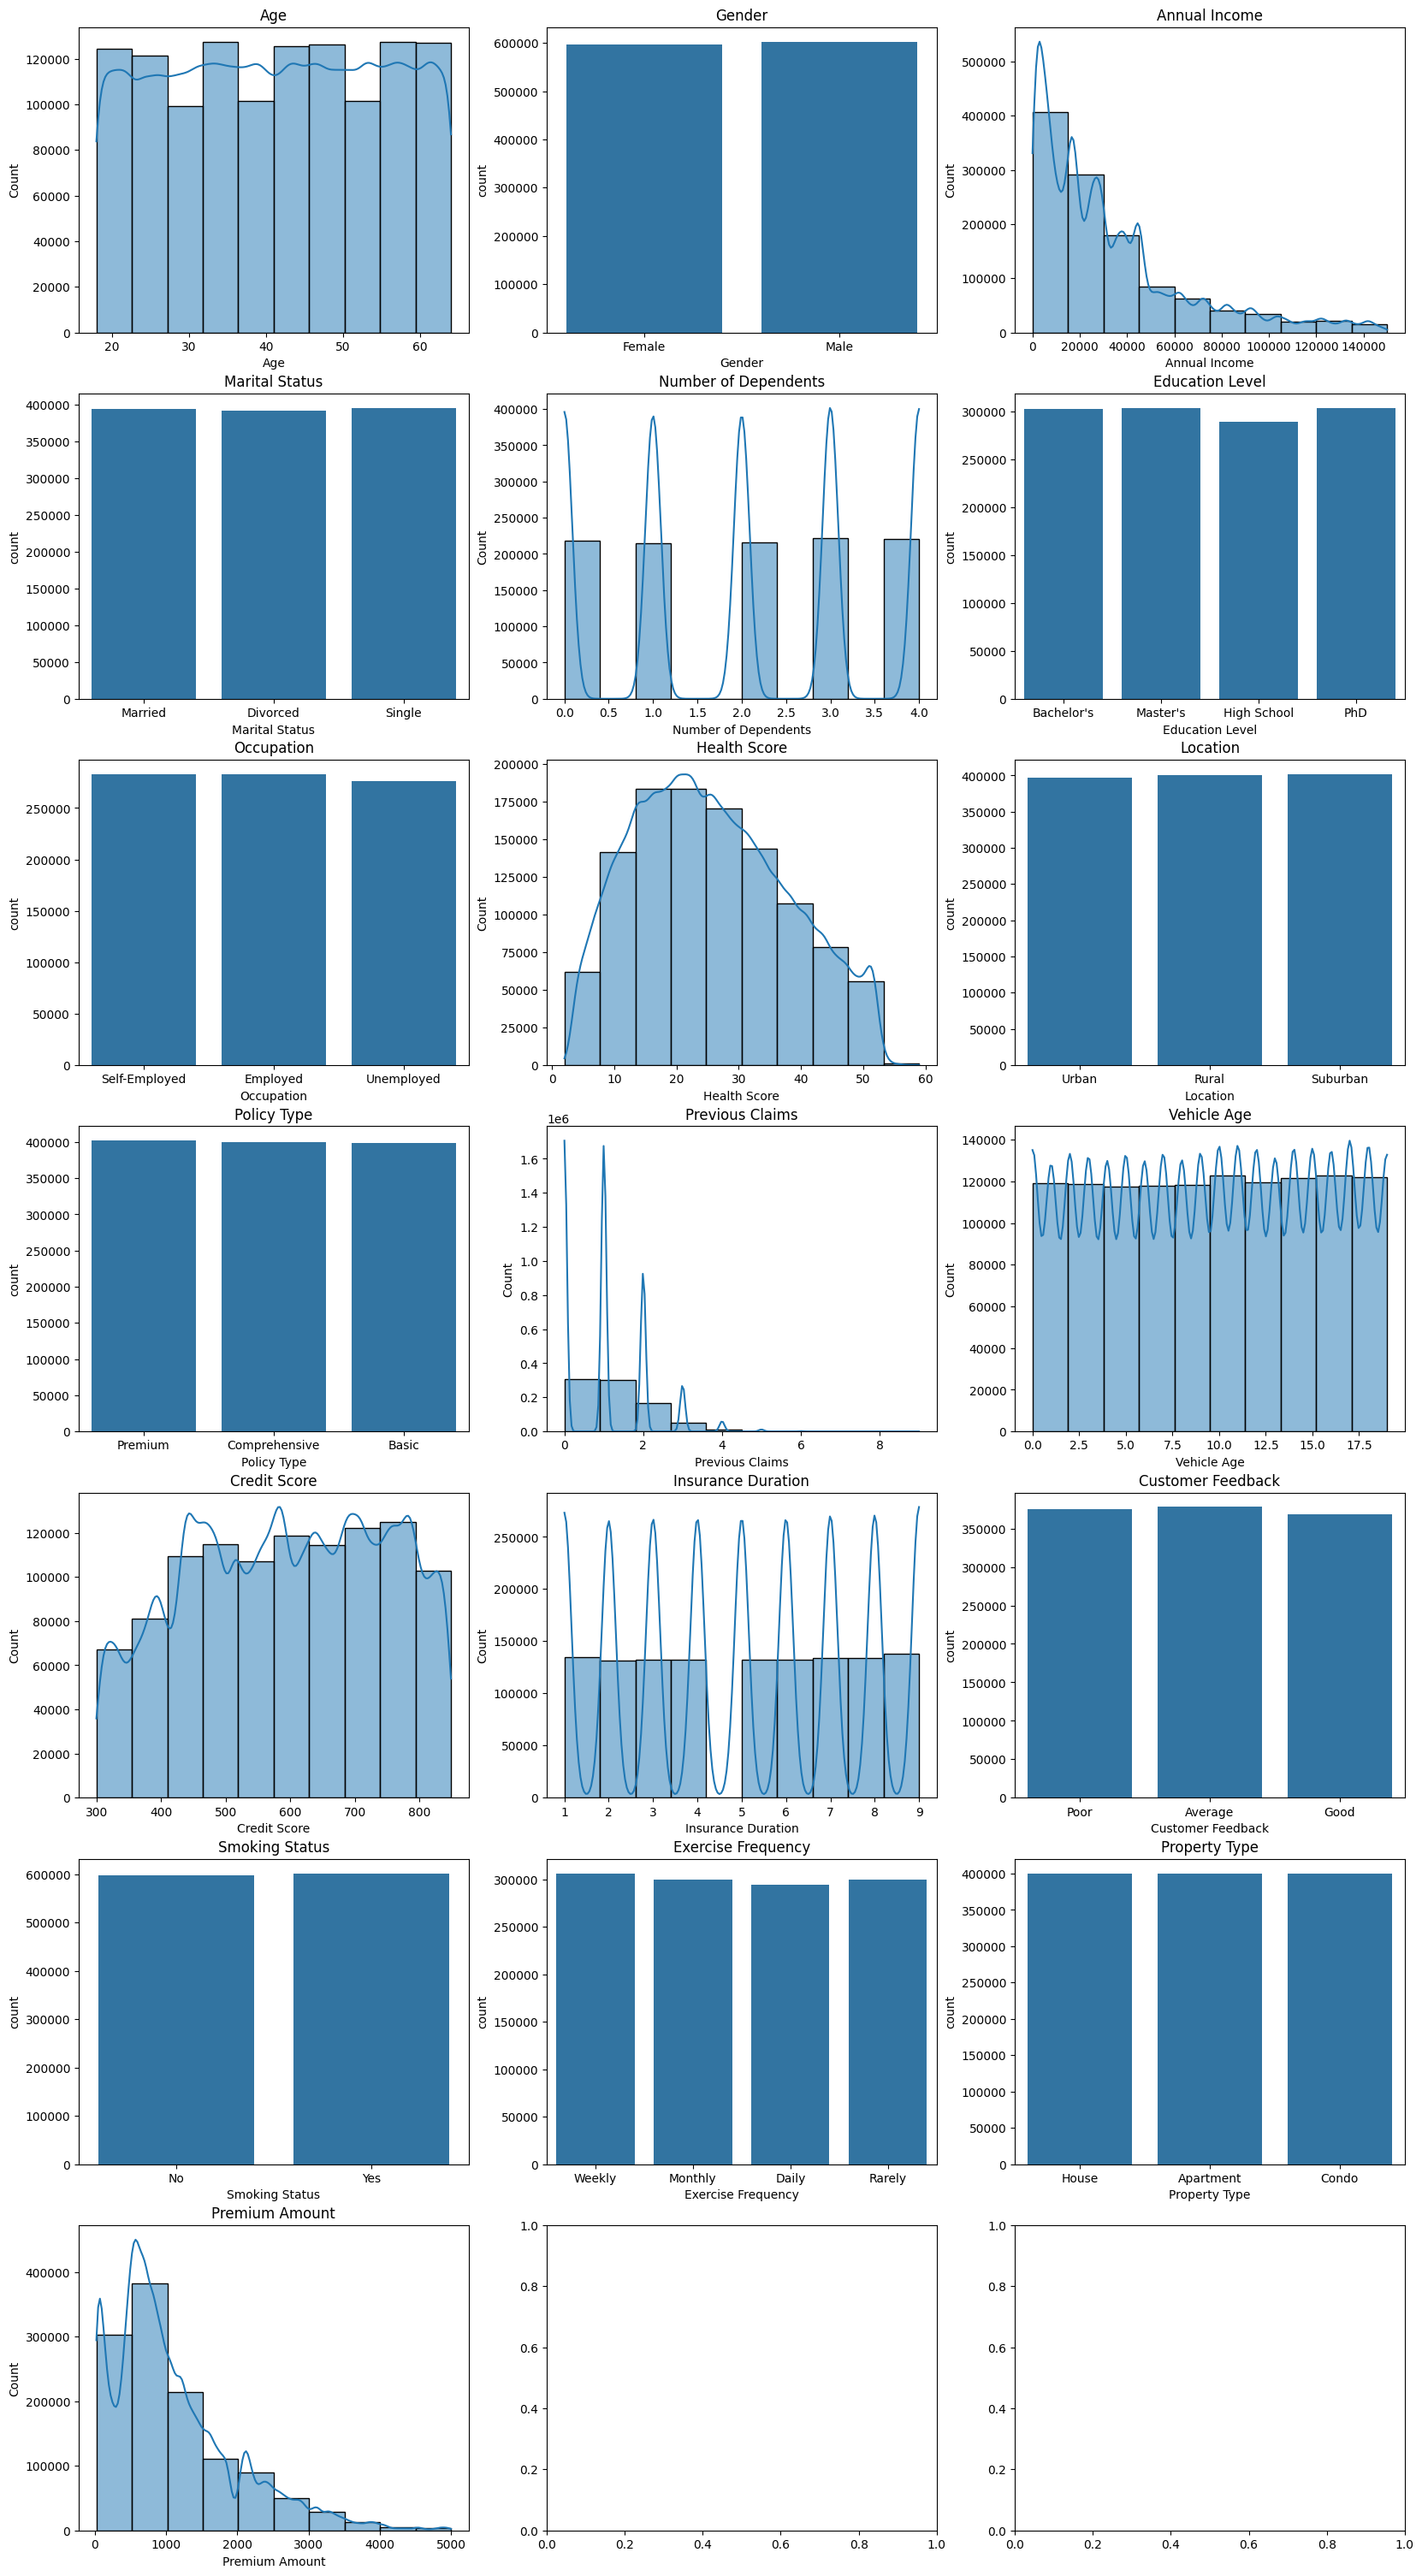

In [13]:
plt.subplots(7, 3, figsize=(20,38))
cat_cols = data.select_dtypes('object').columns

for i, col in enumerate(data.columns):
  plt.subplot(7, 3, i+1)
  plt.title(col)
  if col in cat_cols:
     sns.countplot(x=col, data=data)
  else:
    sns.histplot(data[col],bins=10, kde=True)

<Axes: >

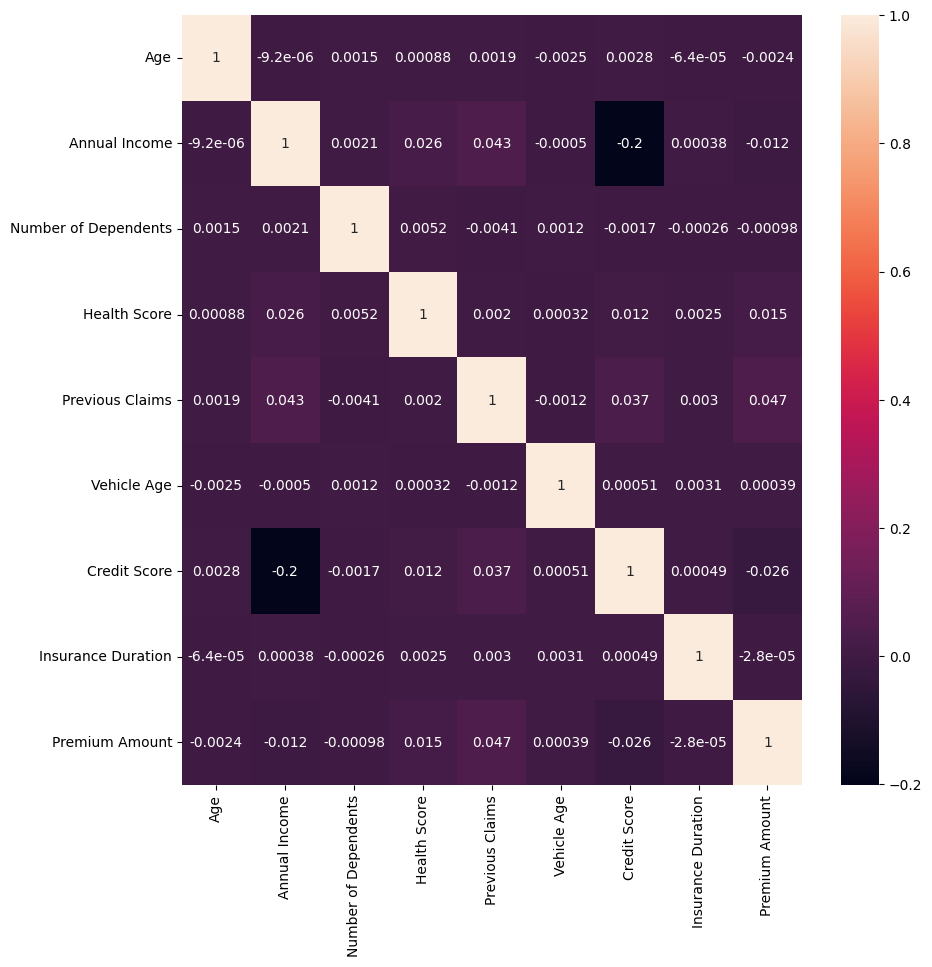

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(data.select_dtypes('number').corr(), annot=True)

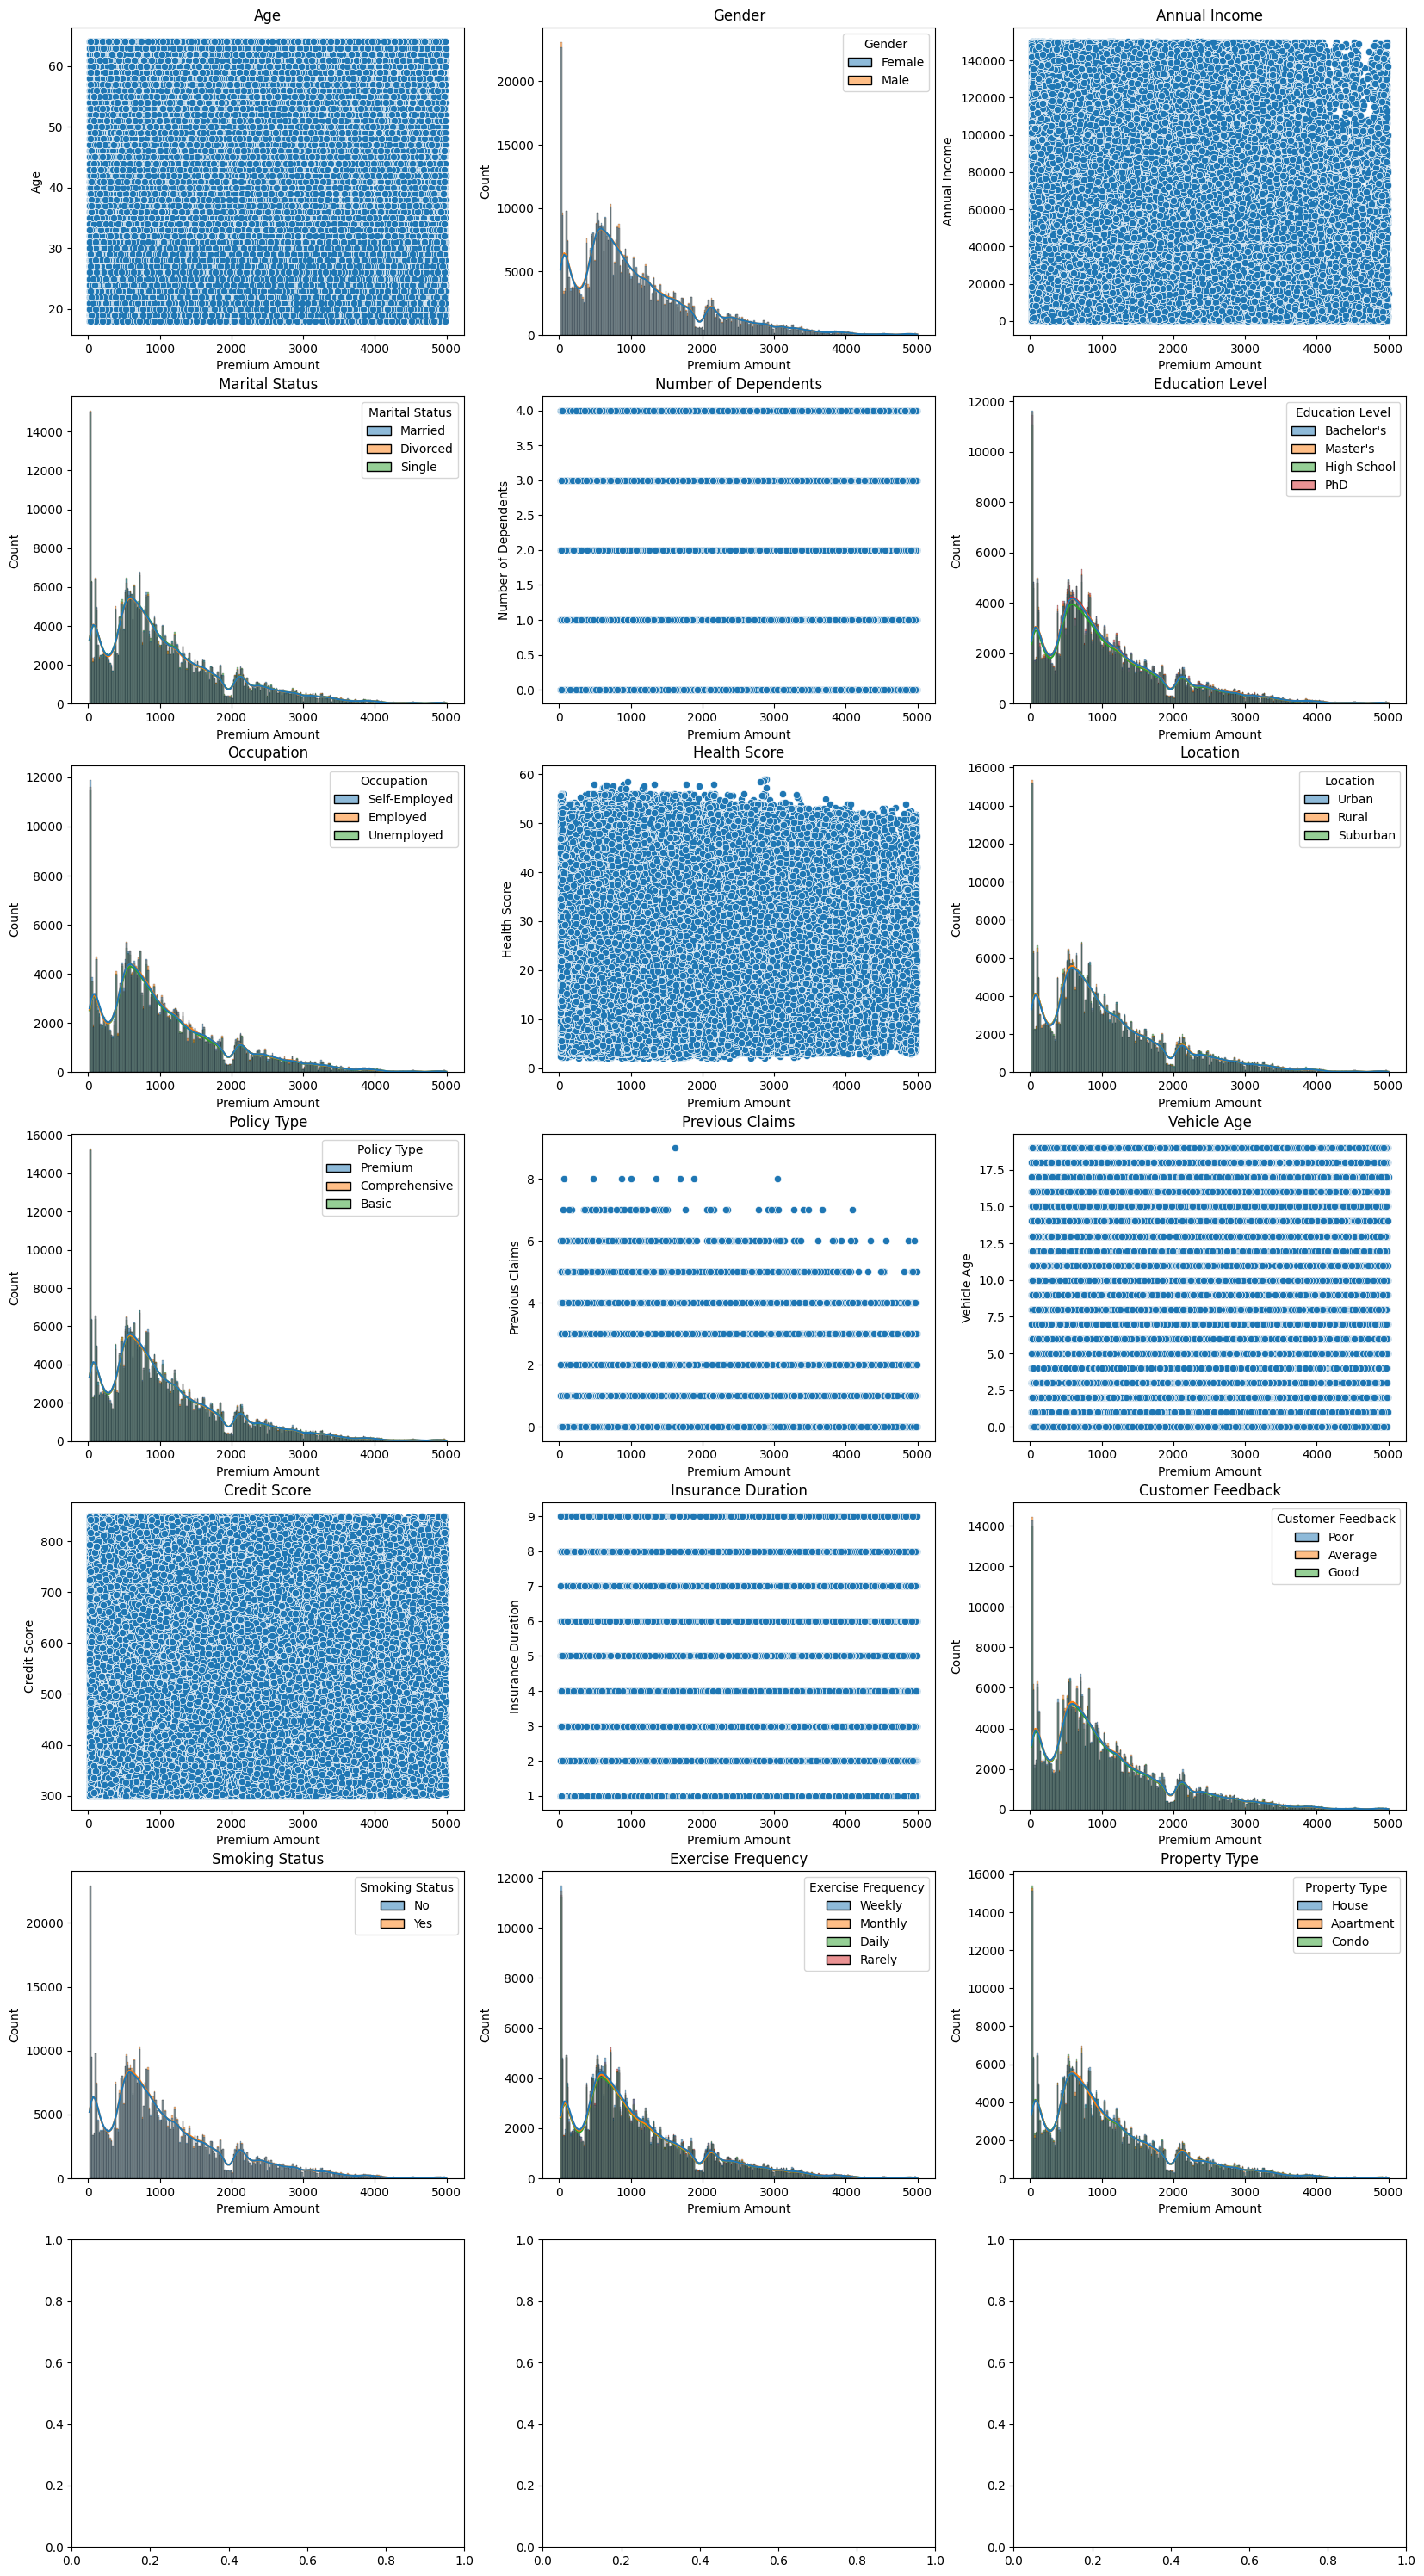

In [15]:
plt.subplots(7, 3, figsize=(20,38))
cat_cols = data.select_dtypes('object').columns

for i, col in enumerate(data.drop(columns=['Premium Amount']).columns):
  plt.subplot(7, 3, i+1)
  plt.title(col)
  if col in cat_cols:
     sns.histplot(x='Premium Amount', data=data, hue=col, kde=True)
  else:
    sns.scatterplot(x='Premium Amount', y=col, data=data)

In [16]:
data.sample(10)

,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Customer Feedback,Smoking Status,Exercise Frequency,Property Type,Premium Amount
294661,23.0,Female,75848.0,Single,3.0,High School,NaN,16.241707,Urban,Comprehensive,0.0,18.0,381.0,4.0,Average,Yes,Daily,Apartment,809.0
417744,49.0,Male,12794.0,Married,0.0,Bachelor's,NaN,13.554888,Rural,Premium,NaN,17.0,493.0,8.0,Average,Yes,Daily,Apartment,821.0
604487,30.0,Female,102887.0,Married,NaN,Master's,Unemployed,22.817056,Rural,Premium,0.0,14.0,393.0,1.0,Good,Yes,Rarely,Condo,3279.0
468211,22.0,Female,28097.0,Married,4.0,Master's,Employed,14.634293,Suburban,Premium,2.0,12.0,NaN,4.0,Average,No,Daily,House,1111.0
823791,22.0,Female,80936.0,Single,1.0,Master's,Employed,15.936507,Suburban,Basic,NaN,12.0,365.0,4.0,Average,Yes,Daily,Apartment,1260.0
760284,26.0,Female,58943.0,Divorced,3.0,Master's,Self-Employed,46.357065,Urban,Premium,1.0,2.0,454.0,7.0,Good,Yes,Daily,House,1000.0
361536,43.0,Female,NaN,Divorced,1.0,Master's,NaN,18.038158,Suburban,Premium,2.0,14.0,544.0,2.0,Good,No,Rarely,Apartment,37.0
301391,41.0,Male,5899.0,Single,0.0,Bachelor's,Employed,24.869121,Urban,Premium,2.0,3.0,614.0,5.0,Good,Yes,Weekly,Apartment,2457.0
284848,42.0,Male,45476.0,Married,4.0,High School,NaN,17.045461,Rural,Comprehensive,2.0,19.0,617.0,1.0,Good,No,Rarely,Apartment,567.0
79557,49.0,Female,43305.0,Married,2.0,PhD,Employed,NaN,Suburban,Basic,NaN,0.0,358.0,2.0,Average,No,Daily,Apartment,842.0


In [17]:
data['Customer Feedback'].value_counts()

,count
Customer Feedback,
Average,377905
Poor,375518
Good,368753


In [53]:
Encoder_1 = ColumnTransformer(
    transformers=[
        ('OHE', OneHotEncoder(sparse_output=False, handle_unknown='ignore', drop='first'), ['Gender', 'Property Type', 'Smoking Status']),
        ('ORDE', OrdinalEncoder(categories=[['Basic', 'Comprehensive', 'Premium'], ['Unemployed','Employed', 'Self-Employed'], ['High School', "Bachelor's", "Master's", 'PhD'], ['Rural', 'Suburban', 'Urban'], ['Poor', 'Average', 'Good' ], ['Rarely', 'Monthly',  'Weekly', 'Daily'], ['Single', 'Married', 'Divorced']], handle_unknown='use_encoded_value', unknown_value=np.nan), ['Policy Type', 'Occupation', 'Education Level', 'Location', 'Customer Feedback',  'Exercise Frequency', 'Marital Status'])
    ],
    remainder='passthrough'
)

transformed_data = Encoder_1.fit_transform(data.drop(columns=['Premium Amount']))

In [19]:
transformed_data = pd.DataFrame(transformed_data, columns=Encoder_1.get_feature_names_out())
transformed_data.head()

,OHE__Gender_Male,OHE__Property Type_Condo,OHE__Property Type_House,OHE__Smoking Status_Yes,ORDE__Policy Type,ORDE__Occupation,ORDE__Education Level,ORDE__Location,ORDE__Customer Feedback,ORDE__Exercise Frequency,ORDE__Marital Status,remainder__Age,remainder__Annual Income,remainder__Number of Dependents,remainder__Health Score,remainder__Previous Claims,remainder__Vehicle Age,remainder__Credit Score,remainder__Insurance Duration,remainder__Premium Amount
0,0.0,0.0,1.0,0.0,2.0,2.0,1.0,2.0,0.0,2.0,1.0,19.0,10049.0,1.0,22.598761,2.0,17.0,372.0,5.0,2869.0
1,0.0,0.0,1.0,1.0,1.0,NaN,2.0,0.0,1.0,1.0,2.0,39.0,31678.0,3.0,15.569731,1.0,12.0,694.0,2.0,1483.0
2,1.0,0.0,1.0,1.0,2.0,2.0,0.0,1.0,2.0,2.0,2.0,23.0,25602.0,3.0,47.177549,1.0,14.0,NaN,3.0,567.0
3,1.0,0.0,0.0,1.0,0.0,NaN,1.0,0.0,0.0,3.0,1.0,21.0,141855.0,2.0,10.938144,1.0,0.0,367.0,1.0,765.0
4,1.0,0.0,1.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,0.0,21.0,39651.0,1.0,20.376094,0.0,8.0,598.0,4.0,2022.0


In [20]:
null_data

,0,Null_Percetange
id,0,0.000
Age,18705,1.559
Gender,0,0.000
Annual Income,44949,3.746
Marital Status,18529,1.544
Number of Dependents,109672,9.139
Education Level,0,0.000
Occupation,358075,29.840
Health Score,74076,6.173
Location,0,0.000


In [21]:
transformed_data.isnull().sum().to_frame().reset_index()

,index,0
0,OHE__Gender_Male,0
1,OHE__Property Type_Condo,0
2,OHE__Property Type_House,0
3,OHE__Smoking Status_Yes,0
4,ORDE__Policy Type,0
5,ORDE__Occupation,358075
6,ORDE__Education Level,0
7,ORDE__Location,0
8,ORDE__Customer Feedback,77824
9,ORDE__Exercise Frequency,0


## **Data Sampling**

In [22]:
Sample = transformed_data.sample(10000)

In [54]:
Imputer = ColumnTransformer(
    transformers = [
        ('impute_1', IterativeImputer(), [14, 0, 3, 9]),
        ('impute_2', IterativeImputer(), [ 11, 12, 17,]),
        ('impute_3', IterativeImputer(), [5, 8, 10, 13, 15, 14]),
        ('impute_4', SimpleImputer(strategy='most_frequent'), [16, 18])
    ]  , remainder='passthrough'
)
imputed_data = Imputer.fit_transform(transformed_data)

In [24]:
pd.DataFrame(imputed_data, columns=Imputer.get_feature_names_out()).isnull().sum().to_frame().reset_index()

,index,0
0,impute_1__remainder__Health Score,0
1,impute_1__OHE__Gender_Male,0
2,impute_1__OHE__Smoking Status_Yes,0
3,impute_1__ORDE__Exercise Frequency,0
4,impute_2__remainder__Age,0
5,impute_2__remainder__Annual Income,0
6,impute_2__remainder__Credit Score,0
7,impute_3__ORDE__Occupation,0
8,impute_3__ORDE__Customer Feedback,0
9,impute_3__ORDE__Marital Status,0


In [25]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMRegressor

In [55]:
X_train, y_train= (imputed_data[:, [0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]], imputed_data[:, -1])

In [66]:
test_data = pd.read_csv("test.csv")
test_data.drop(columns=['id', 'Policy Start Date'], axis=1)
test_data

,id,Age,Gender,Annual Income,Marital Status,Number of Dependents,Education Level,Occupation,Health Score,Location,Policy Type,Previous Claims,Vehicle Age,Credit Score,Insurance Duration,Policy Start Date,Customer Feedback,Smoking Status,Exercise Frequency,Property Type
0,1200000,28.0,Female,2310.0,NaN,4.0,Bachelor's,Self-Employed,7.657981,Rural,Basic,NaN,19.0,NaN,1.0,2023-06-04 15:21:39.245086,Poor,Yes,Weekly,House
1,1200001,31.0,Female,126031.0,Married,2.0,Master's,Self-Employed,13.381379,Suburban,Premium,NaN,14.0,372.0,8.0,2024-04-22 15:21:39.224915,Good,Yes,Rarely,Apartment
2,1200002,47.0,Female,17092.0,Divorced,0.0,PhD,Unemployed,24.354527,Urban,Comprehensive,NaN,16.0,819.0,9.0,2023-04-05 15:21:39.134960,Average,Yes,Monthly,Condo
3,1200003,28.0,Female,30424.0,Divorced,3.0,PhD,Self-Employed,5.136225,Suburban,Comprehensive,1.0,3.0,770.0,5.0,2023-10-25 15:21:39.134960,Poor,Yes,Daily,House
4,1200004,24.0,Male,10863.0,Divorced,2.0,High School,Unemployed,11.844155,Suburban,Premium,NaN,14.0,755.0,7.0,2021-11-26 15:21:39.259788,Average,No,Weekly,House
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
799995,1999995,50.0,Female,38782.0,Married,1.0,Bachelor's,NaN,14.498639,Rural,Premium,NaN,8.0,309.0,2.0,2021-07-09 15:21:39.184157,Average,Yes,Daily,Condo
799996,1999996,NaN,Female,73462.0,Single,0.0,Master's,NaN,8.145748,Rural,Basic,2.0,0.0,NaN,2.0,2023-03-28 15:21:39.250151,Good,No,Daily,Apartment
799997,1999997,26.0,Female,35178.0,Single,0.0,Master's,Employed,6.636583,Urban,Comprehensive,NaN,10.0,NaN,6.0,2019-09-30 15:21:39.132191,Poor,No,Monthly,Apartment
799998,1999998,34.0,Female,45661.0,Single,3.0,Master's,NaN,15.937248,Urban,Premium,2.0,17.0,467.0,7.0,2022-05-09 15:21:39.253660,Average,No,Weekly,Condo


In [63]:
transformed_test_data = Encoder_1.transform(test_data)
imputed_test_data = Imputer.transform(transformed_test_data)
X_test = imputed_test_data[:,[0, 1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]]

In [57]:
Model = LGBMRegressor()
Model.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.118885 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2591
[LightGBM] [Info] Number of data points in the train set: 1200000, number of used features: 17
[LightGBM] [Info] Start training from score 0.997137


LGBMRegressor()

In [64]:
y_pred = Model.predict(X_test)

In [67]:
pd.read_csv("sample_submission.csv")

,id,Premium Amount
0,1200000,1102.545
1,1200001,1102.545
2,1200002,1102.545
3,1200003,1102.545
4,1200004,1102.545
...,...,...
799995,1999995,1102.545
799996,1999996,1102.545
799997,1999997,1102.545
799998,1999998,1102.545


In [69]:
pred = pd.DataFrame({'id':test_data['id'],'Premium Amount':y_pred})

In [70]:
pred.to_csv('submission.csv', index=False)